# DL training

## Setup

In [1]:
import numpy as np, pandas as pd
import os, random
from katlas.data import *
from katlas.train import *
from fastai.vision.all import *
from katlas.dnn import *

In [2]:
seed_everything()

In [3]:
def_device

'cuda'

## Data

In [4]:
df=pd.read_parquet('train/pspa_t5.parquet')

In [5]:
info=Data.get_kinase_info()

info = info[info.pseudo=='0']

info = info[info.kd_ID.notna()]

subfamily_map = info[['kd_ID','subfamily']].drop_duplicates().set_index('kd_ID')['subfamily']
family_map = info[['kd_ID','family']].drop_duplicates().set_index('kd_ID')['family']
group_map = info[['kd_ID','group']].drop_duplicates().set_index('kd_ID')['group']

pspa_info = pd.DataFrame(df.index.tolist(),columns=['kinase'])

pspa_info['subfamily'] = pspa_info.kinase.map(subfamily_map)
pspa_info['family'] = pspa_info.kinase.map(family_map)
pspa_info['group'] = pspa_info.kinase.map(group_map)

In [6]:
df=df.reset_index()

In [7]:
df.columns

Index(['index', '-5P', '-4P', '-3P', '-2P', '-1P', '0P', '1P', '2P', '3P',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1255)

In [8]:
# column name of feature and target
feat_col = df.columns[df.columns.str.startswith('T5_')]
target_col = df.columns[~df.columns.isin(feat_col)][1:]

In [9]:
feat_col

Index(['T5_0', 'T5_1', 'T5_2', 'T5_3', 'T5_4', 'T5_5', 'T5_6', 'T5_7', 'T5_8',
       'T5_9',
       ...
       'T5_1014', 'T5_1015', 'T5_1016', 'T5_1017', 'T5_1018', 'T5_1019',
       'T5_1020', 'T5_1021', 'T5_1022', 'T5_1023'],
      dtype='object', length=1024)

## Split

In [10]:
pspa_info.subfamily.value_counts()

subfamily
Eph      12
Src      11
NEK      10
CK1       7
STE11     7
         ..
ZAK       1
Sev       1
Ret       1
Musk      1
Tie       1
Name: count, Length: 149, dtype: int64

In [11]:
pspa_info.family.value_counts()

family
STE20    27
CAMKL    20
CDK      17
MAPK     12
Eph      12
         ..
STK33     1
Sev       1
Ret       1
Musk      1
Tie       1
Name: count, Length: 92, dtype: int64

In [12]:
pspa_info.group.value_counts()

group
TK          78
CAMK        57
CMGC        52
AGC         52
Other       49
STE         39
TKL         25
CK1         11
Atypical     5
Name: count, dtype: int64

In [13]:
splits = get_splits(pspa_info, group='group',nfold=9)

split0 = splits[0]

GroupKFold(n_splits=9, random_state=None, shuffle=False)
# group in train set: 8
# group in test set: 1


## Dataset

In [14]:
# dataset
ds = GeneralDataset(df,feat_col,target_col)

In [15]:
len(ds)

368

In [16]:
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [17]:
xb,yb = next(iter(dl))

xb.shape,yb.shape

(torch.Size([64, 1024]), torch.Size([64, 23, 10]))

## Model

In [18]:
n_feature = len(feat_col)
n_target = len(target_col)

In [19]:

def get_mlp(): return PSSM_model(n_feature,n_target,model='MLP')

def get_cnn(): return PSSM_model(n_feature,n_target,model='CNN')

In [20]:
model = get_mlp()

In [21]:
logits= model(xb)

In [22]:
logits.shape

torch.Size([64, 23, 10])

## Loss

In [23]:
CE(logits,yb)

tensor(3.2301, grad_fn=<MeanBackward0>)

## Metrics

In [24]:
KLD(logits,yb)

tensor(0.4888, grad_fn=<MeanBackward0>)

In [25]:
JSD(logits,yb)

tensor(0.1021, grad_fn=<MeanBackward0>)

## CV train
> cross-validation

In [26]:
oof_cnn = train_dl_cv(df,feat_col,target_col,
                  splits = splits,
                  model_func = get_cnn,
                  n_epoch=20,lr=3e-3,save='cnn')

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.269060,3.143546,0.404984,0.081563,00:01
1,3.223692,3.146275,0.407714,0.083457,00:00
2,3.187206,3.183710,0.445149,0.089945,00:00
3,3.168466,3.213510,0.474949,0.095037,00:00
4,3.151428,3.250360,0.511799,0.095850,00:00
5,3.129077,3.295904,0.557343,0.096764,00:00
6,3.092045,3.379737,0.641176,0.100406,00:00
7,3.050153,3.463077,0.724516,0.097180,00:00
8,3.009927,3.508782,0.770221,0.096228,00:00
9,2.974360,3.530976,0.792415,0.096346,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.208323,3.117840,0.358446,0.079426,00:00
1,3.091189,2.972385,0.212993,0.053489,00:00
2,3.023240,2.914478,0.155085,0.036497,00:00
3,2.980670,2.882222,0.122829,0.028849,00:00
4,2.956968,2.892510,0.133117,0.031521,00:00
5,2.936406,2.883834,0.124441,0.029801,00:00
6,2.916521,2.872803,0.113411,0.026771,00:00
7,2.898817,2.867244,0.107851,0.025469,00:00
8,2.883082,2.871394,0.112001,0.026386,00:00
9,2.869339,2.879647,0.120254,0.028064,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.207325,3.115193,0.398589,0.086719,00:00
1,3.097927,2.949623,0.233019,0.056236,00:00
2,3.025309,2.879674,0.163071,0.036285,00:00
3,2.985648,2.917087,0.200483,0.043315,00:00
4,2.962924,2.954751,0.238148,0.049796,00:00
5,2.945866,2.895562,0.178958,0.039789,00:00
6,2.924970,2.849533,0.132929,0.030185,00:00
7,2.905612,2.830260,0.113657,0.025817,00:00
8,2.889499,2.844801,0.128197,0.029688,00:00
9,2.875663,2.833028,0.116424,0.026825,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.212177,3.133322,0.442178,0.092641,00:00
1,3.106556,3.004702,0.313558,0.071619,00:00
2,3.032302,2.924537,0.233393,0.047923,00:00
3,2.991408,2.954709,0.263565,0.050648,00:00
4,2.968174,2.931870,0.240725,0.048159,00:00
5,2.950806,2.916796,0.225652,0.045101,00:00
6,2.931854,2.925281,0.234136,0.044713,00:00
7,2.914292,2.914789,0.223645,0.044635,00:00
8,2.897355,2.928928,0.237784,0.045836,00:00
9,2.882802,2.949000,0.257856,0.049210,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.194705,3.130977,0.341532,0.074929,00:00
1,3.085594,2.977972,0.188527,0.048879,00:00
2,3.013692,2.913405,0.123960,0.030272,00:00
3,2.973788,2.917067,0.127621,0.030684,00:00
4,2.949276,2.918989,0.129544,0.030319,00:00
5,2.931125,2.899799,0.110354,0.025940,00:00
6,2.915670,2.903029,0.113584,0.026157,00:00
7,2.898051,2.902057,0.112611,0.026029,00:00
8,2.882174,2.906800,0.117355,0.026956,00:00
9,2.866555,2.902642,0.113197,0.026084,00:00


------fold5------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.200059,3.129740,0.340930,0.074560,00:00
1,3.075892,2.966832,0.178021,0.046580,00:00
2,3.002707,2.912999,0.124188,0.030773,00:00
3,2.964410,2.892187,0.103376,0.024924,00:00
4,2.943762,2.902257,0.113446,0.027689,00:00
5,2.927169,2.901444,0.112634,0.027502,00:00
6,2.908855,2.900654,0.111842,0.027249,00:00
7,2.891726,2.897303,0.108493,0.026128,00:00
8,2.875688,2.877074,0.088263,0.021336,00:00
9,2.861317,2.884102,0.095291,0.023083,00:00


------fold6------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.194345,3.125804,0.310537,0.070330,00:00
1,3.076619,2.947607,0.132340,0.035070,00:00
2,3.005765,2.965863,0.150596,0.034322,00:00
3,2.967664,2.947836,0.132569,0.031117,00:00
4,2.949170,2.930657,0.115390,0.027440,00:00
5,2.929431,2.919086,0.103819,0.023647,00:00
6,2.909898,2.909945,0.094679,0.022008,00:00
7,2.889873,2.941175,0.125908,0.030769,00:00
8,2.872821,3.019504,0.204238,0.042314,00:00
9,2.857681,3.009388,0.194121,0.037455,00:00


------fold7------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.193431,3.132979,0.470934,0.100316,00:00
1,3.075129,2.952929,0.290884,0.064314,00:00
2,3.004288,2.980430,0.318384,0.064712,00:00
3,2.964430,3.106791,0.444746,0.087948,00:00
4,2.943281,3.030717,0.368672,0.071883,00:00
5,2.921506,2.966967,0.304921,0.064954,00:00
6,2.901086,2.966125,0.304080,0.066394,00:00
7,2.882934,2.906911,0.244865,0.056612,00:00
8,2.866958,2.959419,0.297374,0.067109,00:00
9,2.853956,2.950435,0.288389,0.062158,00:00


------fold8------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.204335,3.128751,0.330619,0.071953,00:00
1,3.082736,2.936792,0.138660,0.031960,00:00
2,3.005778,2.975837,0.177705,0.038728,00:00
3,2.966585,2.978967,0.180836,0.040213,00:00
4,2.941424,2.933694,0.135562,0.028999,00:00
5,2.919094,2.920082,0.121951,0.026912,00:00
6,2.902150,2.910596,0.112464,0.024009,00:00
7,2.884098,2.900814,0.102682,0.022055,00:00
8,2.867814,2.900837,0.102706,0.022942,00:00
9,2.854059,2.904717,0.106585,0.023494,00:00


In [27]:
oof_mlp = train_dl_cv(df,feat_col,target_col,
                  splits = splits,
                  model_func = get_mlp,
                  n_epoch=20,lr=3e-3,save='mlp')

------fold0------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.171476,3.139420,0.400859,0.080985,00:00
1,3.106711,3.147713,0.409152,0.082218,00:00
2,3.038125,3.160561,0.422000,0.083707,00:00
3,2.976095,3.189467,0.450906,0.085103,00:00
4,2.928933,3.253317,0.514756,0.087918,00:00
5,2.895859,3.290741,0.552180,0.087818,00:00
6,2.871152,3.370811,0.632249,0.091517,00:00
7,2.852960,3.411198,0.672637,0.090949,00:00
8,2.838817,3.496814,0.758253,0.091359,00:00
9,2.827737,3.521644,0.783083,0.093565,00:00


------fold1------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.138040,3.135045,0.375653,0.082271,00:00
1,3.054276,3.113542,0.354149,0.079574,00:00
2,2.989687,3.048094,0.288702,0.069778,00:00
3,2.937330,2.952537,0.193144,0.050103,00:00
4,2.901045,2.872171,0.112778,0.028355,00:00
5,2.875492,2.863093,0.103700,0.025160,00:00
6,2.856277,2.865705,0.106313,0.025039,00:00
7,2.840961,2.864216,0.104823,0.024369,00:00
8,2.829274,2.864235,0.104842,0.024402,00:00
9,2.820478,2.877947,0.118554,0.027575,00:00


------fold2------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.132754,3.134609,0.418006,0.089472,00:00
1,3.046801,3.113223,0.396620,0.086776,00:00
2,2.980770,3.055556,0.338953,0.078529,00:00
3,2.932360,2.969013,0.252410,0.062473,00:00
4,2.899219,2.899032,0.182429,0.046023,00:00
5,2.875994,2.873559,0.156956,0.038564,00:00
6,2.858054,2.845880,0.129277,0.030850,00:00
7,2.844874,2.827710,0.111107,0.026074,00:00
8,2.834472,2.832326,0.115723,0.026925,00:00
9,2.826840,2.842240,0.125637,0.030043,00:00


------fold3------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.123281,3.132412,0.441268,0.092814,00:00
1,3.042101,3.114030,0.422886,0.090477,00:00
2,2.979384,3.074581,0.383437,0.084360,00:00
3,2.931671,3.003192,0.312048,0.069243,00:00
4,2.900101,2.941841,0.250697,0.052327,00:00
5,2.877186,2.922068,0.230924,0.046006,00:00
6,2.860131,2.931553,0.240409,0.046516,00:00
7,2.847045,2.928376,0.237232,0.045358,00:00
8,2.836282,2.931814,0.240670,0.045169,00:00
9,2.827431,2.939419,0.248275,0.048628,00:00


------fold4------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.124104,3.134452,0.345007,0.075167,00:00
1,3.038496,3.111592,0.322147,0.072473,00:00
2,2.970284,3.048591,0.259146,0.063065,00:00
3,2.920771,2.958019,0.168574,0.043953,00:00
4,2.887409,2.898182,0.108737,0.026950,00:00
5,2.863338,2.887498,0.098053,0.023644,00:00
6,2.845474,2.888538,0.099093,0.023433,00:00
7,2.831556,2.886909,0.097464,0.022886,00:00
8,2.819985,2.892709,0.103265,0.024001,00:00
9,2.810792,2.892037,0.102592,0.023989,00:00


------fold5------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.140697,3.135143,0.346332,0.075070,00:00
1,3.048342,3.119731,0.330920,0.073235,00:00
2,2.979255,3.078922,0.290112,0.067775,00:00
3,2.929077,2.995795,0.206985,0.052510,00:00
4,2.893279,2.975678,0.186867,0.047241,00:00
5,2.868217,2.886815,0.098004,0.024602,00:00
6,2.849210,2.916328,0.127517,0.032733,00:00
7,2.835844,2.884094,0.095283,0.024124,00:00
8,2.824802,2.893069,0.104258,0.026342,00:00
9,2.815038,2.909672,0.120861,0.030394,00:00


------fold6------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.125239,3.143044,0.327778,0.072367,00:00
1,3.036369,3.146004,0.330738,0.072551,00:00
2,2.969717,3.142249,0.326983,0.071680,00:00
3,2.921383,3.125622,0.310355,0.069347,00:00
4,2.886705,3.119030,0.303763,0.067855,00:00
5,2.863236,3.150701,0.335434,0.069734,00:00
6,2.846394,3.105358,0.290092,0.062999,00:00
7,2.833611,3.020862,0.205595,0.049413,00:00
8,2.822827,3.081616,0.266349,0.058375,00:00
9,2.814345,3.046980,0.231713,0.052382,00:00


------fold7------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.110090,3.133375,0.471330,0.100618,00:00
1,3.027103,3.102594,0.440548,0.096998,00:00
2,2.965780,3.024230,0.362184,0.084081,00:00
3,2.917700,2.935767,0.273722,0.061535,00:00
4,2.885562,2.921035,0.258989,0.056032,00:00
5,2.862646,2.910833,0.248788,0.054900,00:00
6,2.845487,2.937936,0.275890,0.060785,00:00
7,2.832792,2.922657,0.260612,0.060340,00:00
8,2.822367,2.944104,0.282059,0.066009,00:00
9,2.813707,2.972666,0.310620,0.072871,00:00


------fold8------
lr in training is 0.003


epoch,train_loss,valid_loss,KLD,JSD,time
0,3.140649,3.132743,0.334611,0.072549,00:00
1,3.045759,3.118004,0.319872,0.070753,00:00
2,2.977565,3.083817,0.285684,0.065886,00:00
3,2.924772,3.019604,0.221472,0.054484,00:00
4,2.889525,3.027496,0.229364,0.055167,00:00
5,2.864700,3.021855,0.223723,0.052769,00:00
6,2.847138,3.056512,0.258380,0.059230,00:00
7,2.833452,3.042546,0.244414,0.056720,00:00
8,2.822788,3.159932,0.361800,0.073176,00:00
9,2.814126,3.136939,0.338807,0.071001,00:00


## ML

In [42]:
from sklearn.neighbors import *
from sklearn.linear_model import *
from sklearn.tree import *
from sklearn.svm import *
from sklearn.ensemble import *
from sklearn.multioutput import MultiOutputRegressor

In [89]:
ml_models = {
    'LinearRegression': LinearRegression(),
    'Lasso': Lasso(0.1), # L1 regularization # changing alpha does not change the result
    'Ridge': Ridge(alpha=0.1), # L2 regularization
    'ElasticNet': ElasticNet(0.1), # Combine L1 and L2
    
    # 'SVR':SVR(C=10,gamma=1),
    'DecisionTreeRegressor': DecisionTreeRegressor(), # not very good
    'KNN': KNeighborsRegressor(n_neighbors=3), # compared with others, n=3 gives the best results
    # 'XGBRegressor': XGBRegressor(), #slow without gpu
    # 'RandomForestRegressor': RandomForestRegressor() # slow, use cuml to use gpu
                                      }

In [90]:
oofs_ml = {}

In [108]:
for name,model in ml_models.items():
    oofs_ml[name] = train_ml_cv(df, feat_col, target_col, splits, model)

/home/sky1ove/git/KATLAS/katlas/.venv/lib/python3.12/site-packages/logomaker/../sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/sky1ove/git/KATLAS/katlas/.venv/lib/python3.12/site-packages/logomaker/../sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/home/sky1ove/git/KATLAS/katlas/.venv/lib/python3.12/site-packages/logomaker/../sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

## Score

In [92]:
target=df[target_col].copy()

In [93]:
pspa_info['split'] = oof_cnn.nfold

In [128]:
pspa_info['MLP'] =get_score_jsd(target,oof_mlp)
pspa_info['CNN'] =get_score_jsd(target,oof_cnn)

In [95]:
from tqdm import tqdm

In [109]:
def post_process_oof(oof_ml,target_col):
    oof = oof_ml.copy()
    oof[target_col] = oof.apply(lambda r: pd.Series(flatten_pssm(post_process(recover_pssm(r[target_col])),column_wise=False)), axis=1)
    return oof

In [110]:
for name,oof in tqdm(oofs_ml.items()):
    oof = post_process_oof(oof,target_col)
    pspa_info[name] = get_score_jsd(target,oof)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:19<00:00,  3.29s/it]


In [48]:
from katlas.plot import *

In [99]:
set_sns()

In [112]:
pspa_info

,kinase,subfamily,family,group,split,mlp,cnn,LinearRegression,Lasso,Ridge,ElasticNet,DecisionTreeRegressor,KNN
0,Q2M2I8_AAK1_HUMAN_KD1,NAK,NAK,Other,4,0.048600,0.051749,0.098876,0.067539,0.056838,0.067539,0.074387,0.048014
1,P27037_AVR2A_HUMAN_KD1,STKR2,STKR,TKL,6,0.044587,0.029739,0.088647,0.037442,0.040927,0.037442,0.100231,0.095125
2,Q13705_AVR2B_HUMAN_KD1,STKR2,STKR,TKL,6,0.043153,0.036690,0.086192,0.039007,0.042801,0.039007,0.099457,0.093459
3,P31749_AKT1_HUMAN_KD1,Akt,Akt,AGC,2,0.023194,0.019785,0.084334,0.042558,0.039124,0.042558,0.055568,0.068775
4,P31751_AKT2_HUMAN_KD1,Akt,Akt,AGC,2,0.015898,0.013228,0.067616,0.038013,0.031472,0.038013,0.020330,0.040728
...,...,...,...,...,...,...,...,...,...,...,...,...,...
363,P17948_VGFR1_HUMAN_KD1,VEGFR,VEGFR,TK,0,0.089577,0.090952,0.150470,0.095850,0.107327,0.095850,0.089927,0.088376
364,P35968_VGFR2_HUMAN_KD1,VEGFR,VEGFR,TK,0,0.085835,0.085874,0.161182,0.088967,0.099599,0.088967,0.087649,0.085550
365,P35916_VGFR3_HUMAN_KD1,VEGFR,VEGFR,TK,0,0.088425,0.090141,0.170160,0.092814,0.109089,0.092814,0.099440,0.095619
366,P07947_YES_HUMAN_KD1,Src,Src,TK,0,0.095206,0.092859,0.127592,0.093916,0.103253,0.093916,0.100129,0.094951


In [113]:
pspa_info.columns

Index(['kinase', 'subfamily', 'family', 'group', 'split', 'mlp', 'cnn',
       'LinearRegression', 'Lasso', 'Ridge', 'ElasticNet',
       'DecisionTreeRegressor', 'KNN'],
      dtype='object')

In [129]:
model_list = ['MLP','CNN']+list(ml_models.keys())

In [130]:
ordered_list = pspa_info[model_list].mean().sort_values(ascending=False).index
ordered_list

Index(['LinearRegression', 'DecisionTreeRegressor', 'KNN', 'Ridge', 'Lasso',
       'ElasticNet', 'MLP', 'CNN'],
      dtype='object')

In [148]:
def plot_group_bar(df, 
                   value_cols,  # list of column names for values, the order depends on the first item
                   group,       # column name of group (e.g., 'kinase')
                   figsize=(12, 5),
                   order=None,
                   title=None,
                   fontsize=14,
                   rotation=90,
                   **kwargs):
    
    " Plot grouped bar graph from dataframe. "

    # Prepare the dataframe for plotting
    # Melt the dataframe to go from wide to long format
    df_melted = df.melt(id_vars=group, value_vars=value_cols, var_name='Ranking', value_name='Value')

    plt.figure(figsize=figsize)
    
    # Create the bar plot
    sns.barplot(data=df_melted, 
                x=group, 
                y='Value', 
                hue='Ranking', 
                order=order, 
                capsize=0.1,
                err_kws={'linewidth': 1.5,'color': 'gray'}, 
                **kwargs)
    
    # Increase font size for the x-axis and y-axis tick labels
    plt.tick_params(axis='x', labelsize=fontsize)  # Increase x-axis label size
    plt.tick_params(axis='y', labelsize=fontsize)  # Increase y-axis label size
    
    # Modify x and y label and increase font size
    plt.xlabel('', fontsize=fontsize)
    plt.ylabel('Value', fontsize=fontsize)
    
    # Rotate X labels
    plt.xticks(rotation=rotation)
    
    # Plot titles
    if title is not None:
        plt.title(title, fontsize=fontsize)
    
    plt.gca().spines[['right', 'top']].set_visible(False)
    plt.legend(
        fontsize=fontsize,
        loc="upper left",
        # alpha=0.2
        # bbox_to_anchor=(1.02, 1),
        # borderaxespad=0
    )

In [136]:
import seaborn as sns

In [142]:
pspa_info.to_parquet('raw/model_compare_results.parquet')

Text(0.5, 1.0, 'Comparison of models')

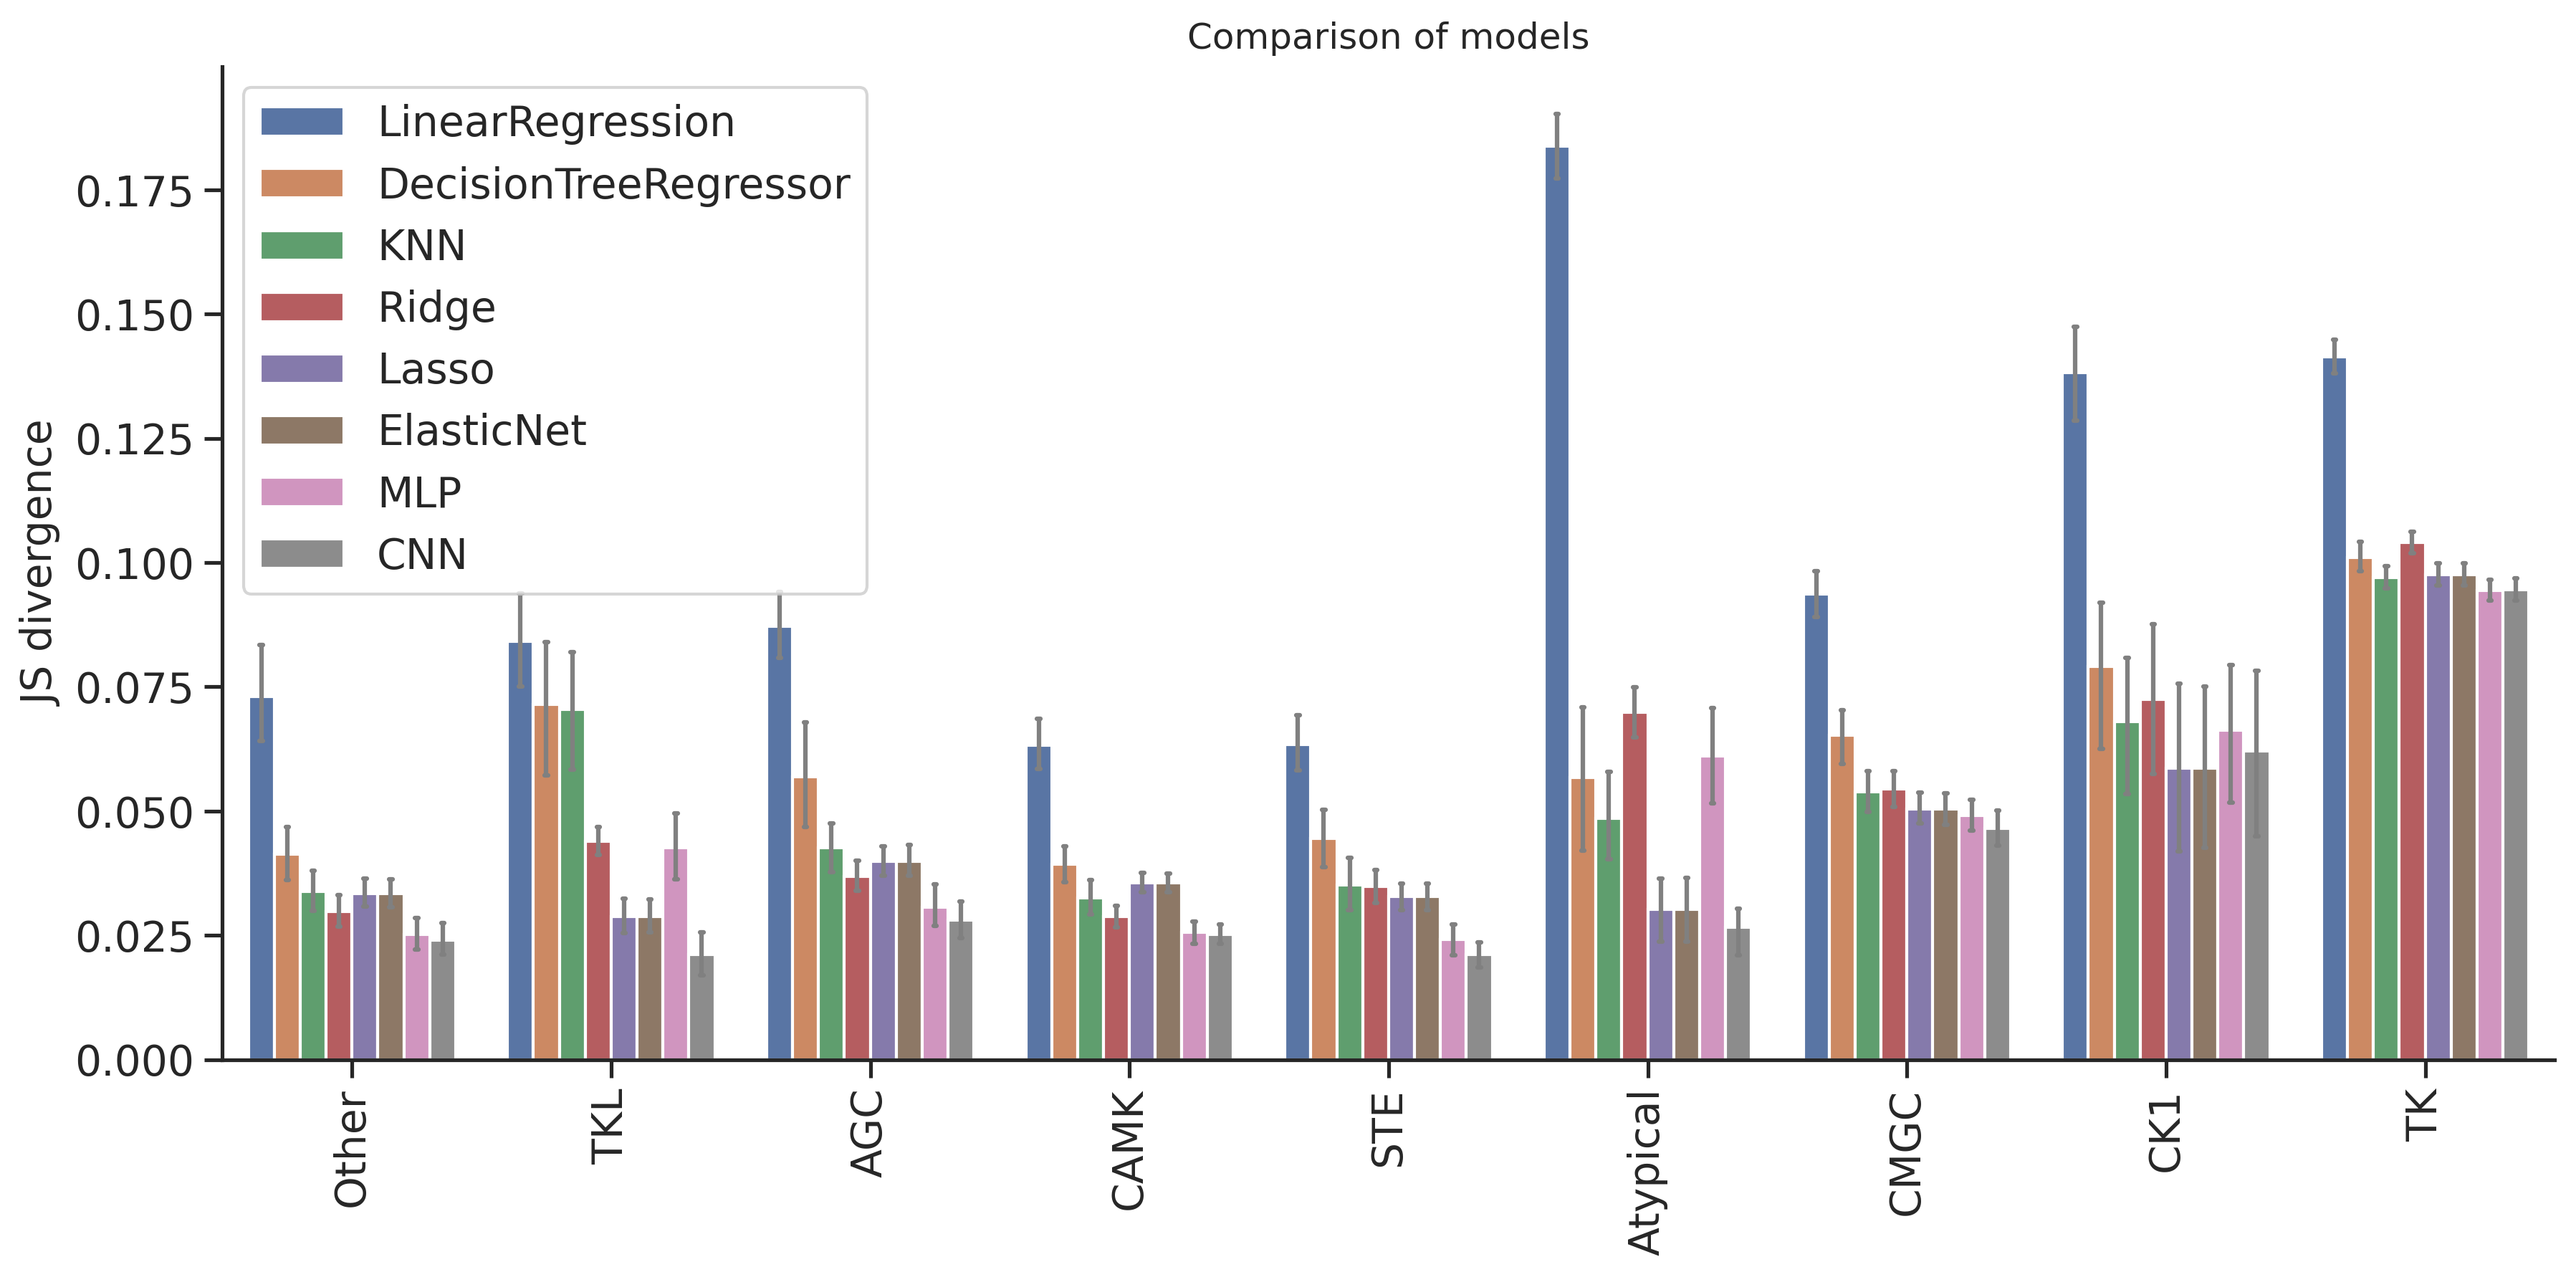

In [150]:
plot_group_bar(pspa_info,ordered_list,group='group',figsize=(14,6))
plt.ylabel('JS divergence')
plt.title('Comparison of models')
# save_svg()